<a href="https://colab.research.google.com/github/JulieLewis/MalariaDetector/blob/main/Reference_Notebook_Malaria_Detection_Full_Code_JulieLewis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malaria Detection**

##<b>Problem Definition</b>
**The context:** Malaria is a critical health issue reporting an estimated 249 million cases and 608,000 deaths worldwide in 2022. The impact is mainly felt in Africa, which accounts for 94% of all cases. [1]

Diagnosing and treating malaria can prevent deaths and reduce transmission. However, antimalarial drug resistance is also a global concern so accuracy is important.[1]

Microscopic examination of blood samples performed by skilled technicians is the gold standard for diagnosing malaria.[2] This process can be time-consuming and yield varying results.[3] Convolutional Neural Networks (CNNs) and their talent for feature extraction offer the potential for automated diagnosis.

Ideally, this model should be suitable for field clinics and give quick results.

**The objectives:** Develop an accurate CNN model to detect malarial infections. This system should categorize images of blood cells as parasitized or uninfected without being too computationally intensive.<br>
**The key questions:**
* What are the general characteristics of the images?
* What differentiates parasitized and unparasitized cells?
* What methods are beneficial in preparing the images for our CNN models?
* How do pre-trained models compare with models trained solely on the dataset?
* What is the most accurate and efficient model?

**The problem formulation:**
* We will approach the diagnosis of malaria as a supervised learning task using CNNs. We will explore different methods of preparing the images such as filters, mean images and data augmentation. We will optimize accuracy (not just precision or recall) since malaria is a common disease and there are serious implications involved in excessive false negative and false positive diagnoses. We will train models of varying complexity in an attempt to determine the best model.





[1] [World Malaria Report 2023](https://www.who.int/publications/i/item/9789240086173)

[2] [WHO Guidelines for Malaria, October 15 2023](https://www.who.int/publications/i/item/guidelines-for-malaria)

[3] [Capstone Project Problem Statement](https://olympus.mygreatlearning.com/courses/102143/files/9062846?module_item_id=5735586)
## <b>Data Description </b>


There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


###<b> Mount the Drive

In [ ]:
# Mount the colab drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Upgrade to the most recent version of tensorflow
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 38.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    F

### <b>Loading libraries</b>

In [ ]:
import os
import zipfile
import cv2

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [ ]:
print(tf.__version__)

2.16.1


In [ ]:
pd.options.display.float_format = '{:,.0f}'.format

### <b>Let us load the data</b>

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same to your Google Drive. Then unzip the folder.

In [ ]:
root_path = '/content/drive/MyDrive/Malaria'

# Extract the images from the zip file
with zipfile.ZipFile(os.path.join( '/content/drive/MyDrive/Malaria/cell_images.zip'), 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name.

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model.

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [ ]:
# Get the shape of each image in a directory
def get_image_shapes(image_directory, data, label):
    path = os.path.join(image_directory, data, label)
    image_files = os.listdir(path)
    image_array = [img_to_array(load_img(os.path.join(path, image_file))).shape for image_file in image_files]
    return pd.DataFrame(image_array, columns=('length','width','layers'))

In [ ]:
image_directory = '/content/sample_data/cell_images'

In [ ]:
for set in ('test', 'train'):
    for label in ('parasitized', 'uninfected'):
        print (f"{label} images in the {set} dataset")
        print(get_image_shapes(image_directory, set, label).describe().T)
        print()

parasitized images in the test dataset
        count  mean  std  min  25%  50%  75%  max
length  1,300   135   22   67  121  133  148  241
width   1,300   135   21   73  121  133  148  232
layers  1,300     3    0    3    3    3    3    3

uninfected images in the test dataset
        count  mean  std  min  25%  50%  75%  max
length  1,300   131   20   70  118  130  142  223
width   1,300   131   20   61  118  130  142  220
layers  1,300     3    0    3    3    3    3    3

parasitized images in the train dataset
        count  mean  std  min  25%  50%  75%  max
length 12,582   135   22   58  121  133  145  382
width  12,582   134   21   46  121  133  145  364
layers 12,582     3    0    3    3    3    3    3

uninfected images in the train dataset
        count  mean  std  min  25%  50%  75%  max
length 12,376   131   19   40  118  130  142  385
width  12,376   131   19   49  118  130  142  394
layers 12,376     3    0    3    3    3    3    3



####<b> Observations and insights:
* The Train Folder contains 12,582 parasitized and 12,376 uninfected images
* The Test Folder contains 1,300 parasitized and 1,300 uninfected images

* The images are all tensors of rank 3
* The size of the images vary greatly, from 40 to 394 (possibly due to variation in equiment quality)
* The average of all of the image sets is ~ 130 x 130 pixels.
* Note: The originial picture size was set to 130. Since every pixel adds to the complexity of the model and the images do not appear to be of a high resolution, the picture size was reduced to 100 x 100 pixels which improved speed of models without reducing accuracy

In [ ]:
# Set length and width of image matrices
picture_size = 100

# Storing all images and labels in an array
def get_images(image_directory, set, target_size=picture_size):
    image_array = []
    label_array = []
    path = os.path.join(image_directory, set)
    labels = os.listdir(path)
    for label in labels:
        label_path = os.path.join(path, label)
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            image_array.append(img_to_array(load_img(image_path, target_size=(target_size, target_size))))
            label_array.append(label)
    return np.array(image_array), np.array(label_array)


In [ ]:
# Create initial test and training sets
test_images_raw, test_labels = get_images(image_directory, 'test')
train_images_raw, train_labels = get_images(image_directory, 'train')

###<b> Check the shape of train and test images

In [ ]:
print(f"The shape of the train images are: {train_images_raw.shape}")
print(f"The shape of the test images are: {test_images_raw.shape}")

The shape of the train images are: (24958, 100, 100, 3)
The shape of the test images are: (2600, 100, 100, 3)


###<b> Check the shape of train and test labels

In [ ]:
print(f"The shape of the train labels are: {train_labels.shape}")
print(f"The shape of the test labels are: {test_labels.shape}\n")

The shape of the train labels are: (24958,)
The shape of the test labels are: (2600,)



### <b>Check the minimum and maximum range of pixel values for train and test images

In [ ]:
print(f"The train images got from min: {train_images_raw.min()} to max: {train_images_raw.max()}")
print(f"The test images got from min: {test_images_raw.min()} to max: {test_images_raw.max()}")

The train images got from min: 0.0 to max: 255.0
The test images got from min: 0.0 to max: 255.0


####<b> Observations and insights:

* We have 24,958 train and 2,600 test images and labels: this matches the data description
* All images are represented by (100, 100, 3) tensors
* The pixels range from 0 - 255
* The labels are parasitized and uninfected


###<b> Count the number of values in both uninfected and parasitized

In [ ]:
unique_values, counts = np.unique(train_labels, return_counts=True)
print (f"The training set has:")
for value, count in zip(unique_values, counts):
    print (f"{count} {value} images")
print()
unique_values, counts = np.unique(test_labels, return_counts=True)
print (f"The test set has:")
for value, count in zip(unique_values, counts):
    print (f"{count} {value} images")

The training set has:
12582 parasitized images
12376 uninfected images

The test set has:
1300 parasitized images
1300 uninfected images


###<b>Normalize the images

In [ ]:
# Normalize the train and the test dataset by dividing by 255
X_train = train_images_raw / 255
X_test = test_images_raw / 255

In [ ]:
print(f"The train images got from min: {X_train.min()} to max: {X_train.max()}")
print(f"The test images got from min: {X_test.min()} to max: {X_test.max()}")

The train images got from min: 0.0 to max: 1.0
The test images got from min: 0.0 to max: 1.0


####<b> Observations and insights:
* All images are represented by pixels that range from 0-1
* The normalized RGB image tensors are saved in X_train and X_test variables
* We have performed the basic image preprocessing for the CNNs models

###<b> Plot to check if the data is balanced

Uninfected and Parasitized Image counts
parasitized : 12582
uninfected : 12376


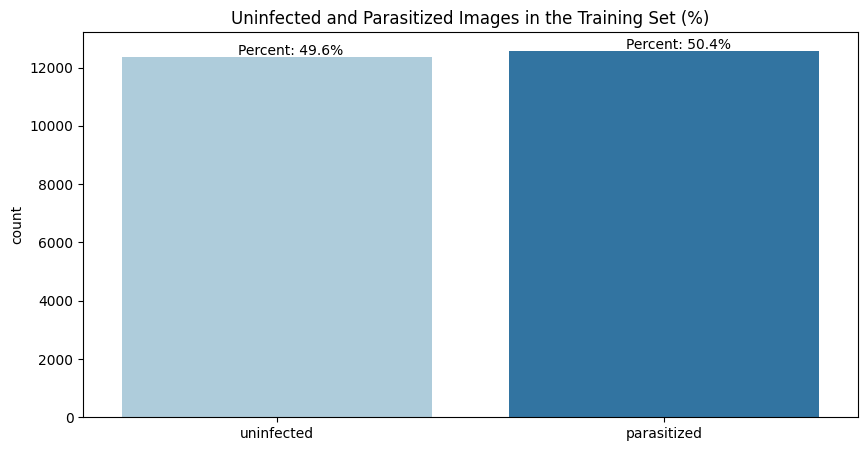

In [ ]:
# Count of the 2 classes in the training set
unique_values, counts = np.unique(train_labels, return_counts=True)
print (f'Uninfected and Parasitized Image counts')
for value, count in zip(unique_values, counts):
    print (f"{value} : {count}")

# Create the Historgram
plt.figure(figsize=(10, 5))
plt.title('Uninfected and Parasitized Images in the Training Set (%)')
ax = sns.countplot(x=train_labels, palette="Paired", hue=train_labels)

# Annotate with percentage
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / len(train_labels))
    x = p.get_x() + p.get_width() / 2  - .1
    y = p.get_y() + p.get_height() + 50
    ax.annotate(f"Percent: {percentage}", (x, y), size = 10)

plt.show()

####<b> Observations and insights:
* The representation of uninfected and parasitized cells are evenly balanced in the training set
* We do not have to worrry about an Imbalanced Classification

### <b>Data Exploration</b>
Let's visualize the images from the train data

In [ ]:
def plot_random_images(image_set, label_set, rows=3, columns=8, figsize=(16,6), title_extra=""):
  # Randomly select row * column images - default 24
  random_array = np.random.randint(1, len(label_set), size=rows * columns)

  # Create the plot
  fig, axs = plt.subplots(nrows=rows, ncols=columns,figsize=figsize, constrained_layout=True)
  axs = axs.flat

  # Display each Test image with it's actual value, predicated value and confidence
  for ax in axs:
      i = axs.index -1
      ax.imshow(image_set[random_array[i]])
      ax.set_title(label_set[random_array[i]].capitalize())
      ax.axis('off')

  fig.suptitle(f'{rows * columns} Random {title_extra}Images')
  plt.show()

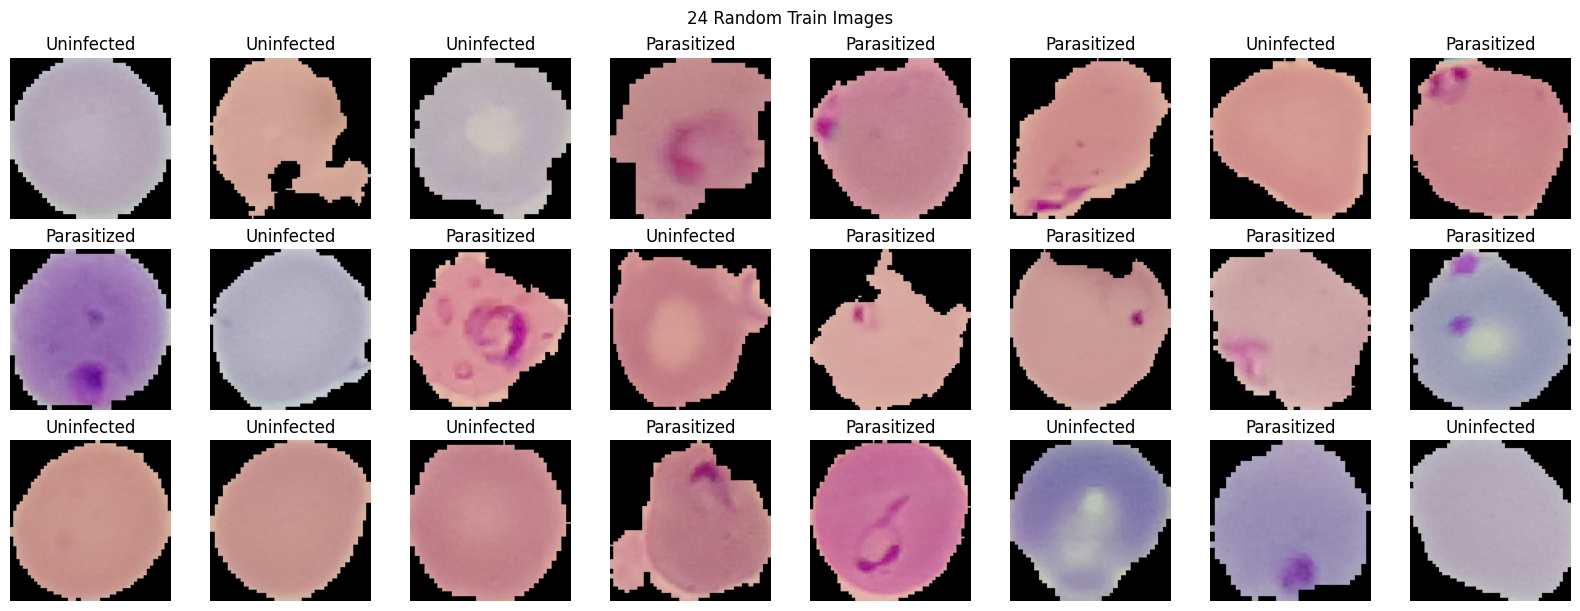

In [ ]:
plot_random_images(X_train, train_labels, title_extra='Train ')

#### <b>Observations and insights:
* The cells are amorphous circular objects that take up the majority of the image
* There are significant variations in shape, colour and brightness.
 * Many of the cells are rounded but some are more irregular and shrunken
 * Colours can range from off-white, to pink, blue or purple
* Some cells contain white patches
* Paraitized cells have one or more irregular purple shapes that vary in size and placement inside the cell. We can presume this to be the Plasmodium parasite.




###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)

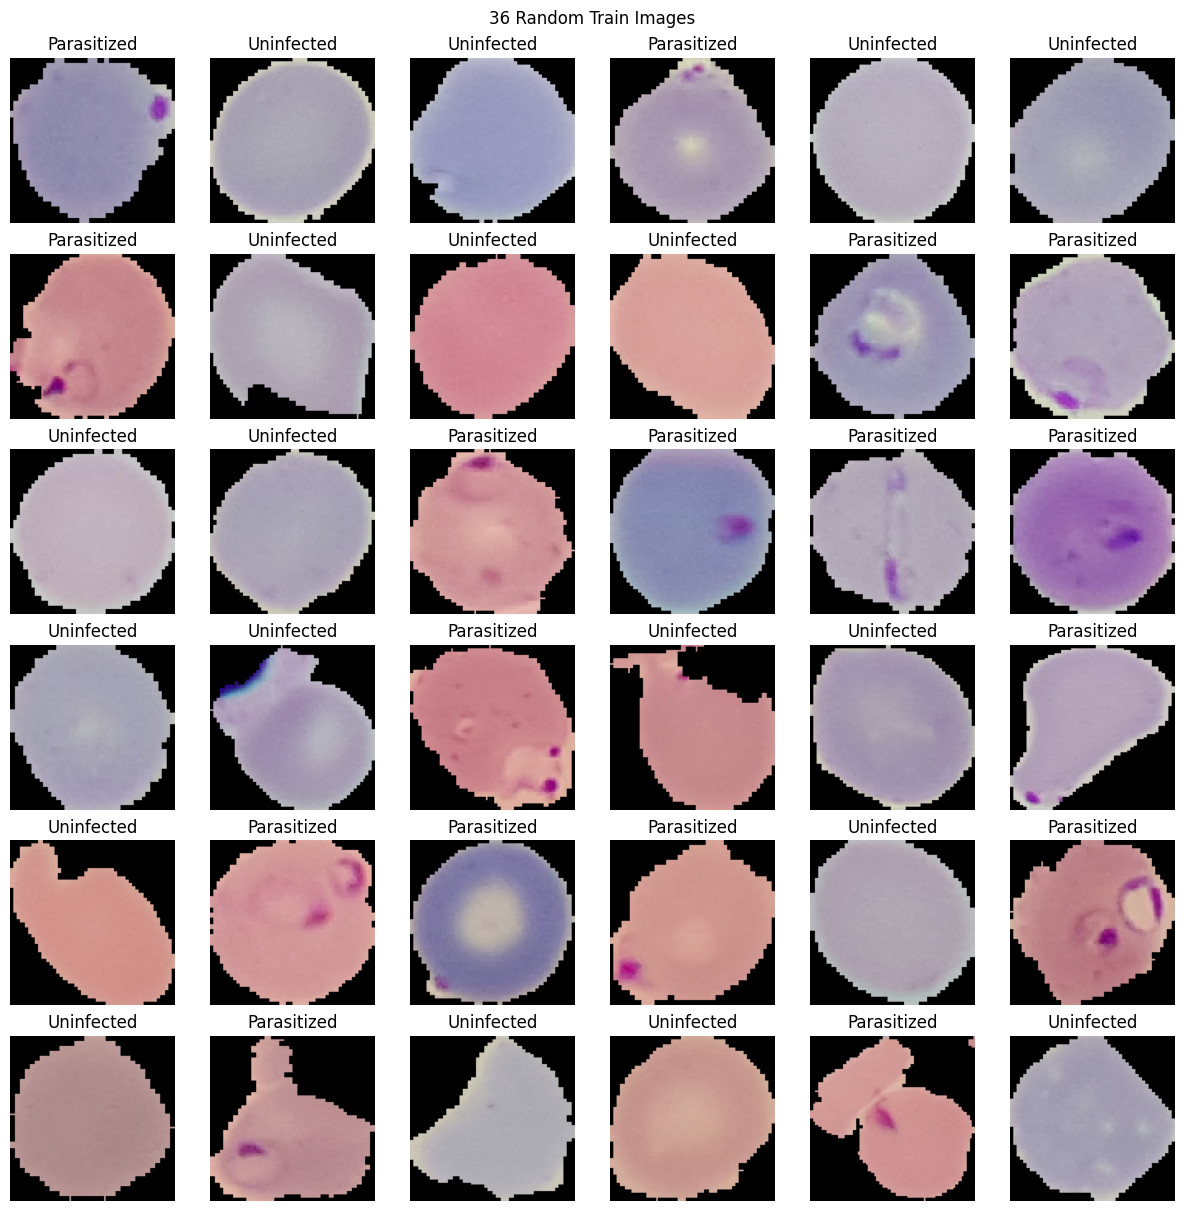

In [ ]:
# Plot 6 rows and 6 columns in a 12 x 12 plot
plot_random_images(X_train, train_labels, rows=6, columns=6, figsize=(12,12), title_extra='Train ')

####<b>Observations and insights:
* This is a similiar presentation to the previous graph.

###<b> Plotting the mean images for parasitized and uninfected

In [ ]:
def plot_mean_image(image_array, Title='Mean Image'):
    # Compute the mean along the first axis to get the mean RGB values
    mean_image = np.mean(image_array, axis=0)

    # Plot the mean image
    plt.title(Title)
    plt.imshow(mean_image)
    plt.axis('off')
    plt.show()

<b> Mean image for parasitized

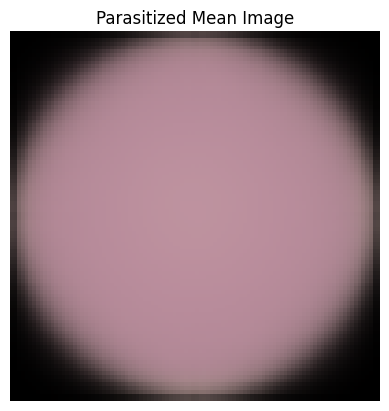

In [ ]:
# Separate out of parasitized images and plot
parasitized = [image for image, label in zip(X_train, train_labels) if label == 'parasitized']
plot_mean_image(parasitized, Title='Parasitized Mean Image')

<b> Mean image for uninfected

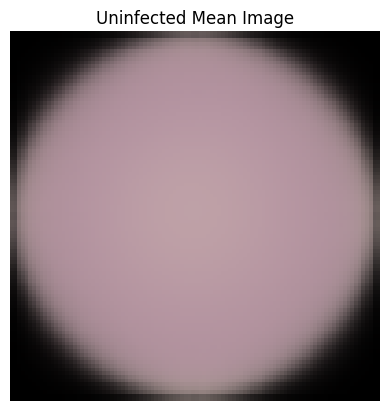

In [ ]:
# Separate out of uninfected images and plot
uninfected = [image for image, label in zip(X_train,train_labels) if label == 'uninfected']
plot_mean_image(uninfected, Title='Uninfected Mean Image')


####<b> Observations and insights:
* The mean images for parasitized and uninfected cells are similar: both show a centred pink circle (the cell) with dark corners.
* The uninfected mean image is lighter. This could be due to several factors:
  * The presence of darker parasites in the parasitized cells
  * There may be variations in brightness from different equipment. It could be coincidental that brighter slides come from places with more uninfected samples
* We should always keep in mind the decrease in human readability when applying transformations such as subtracting the mean image. This can make it difficult for medical professionals who may want to analyze the findings or complicate the preparation of data
* We already preformed a normalizing our images

### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data

In [ ]:
# Convert from RBG to HSV
HSV_train_images = [cv2.cvtColor(image, cv2.COLOR_BGR2HSV) for image in X_train]

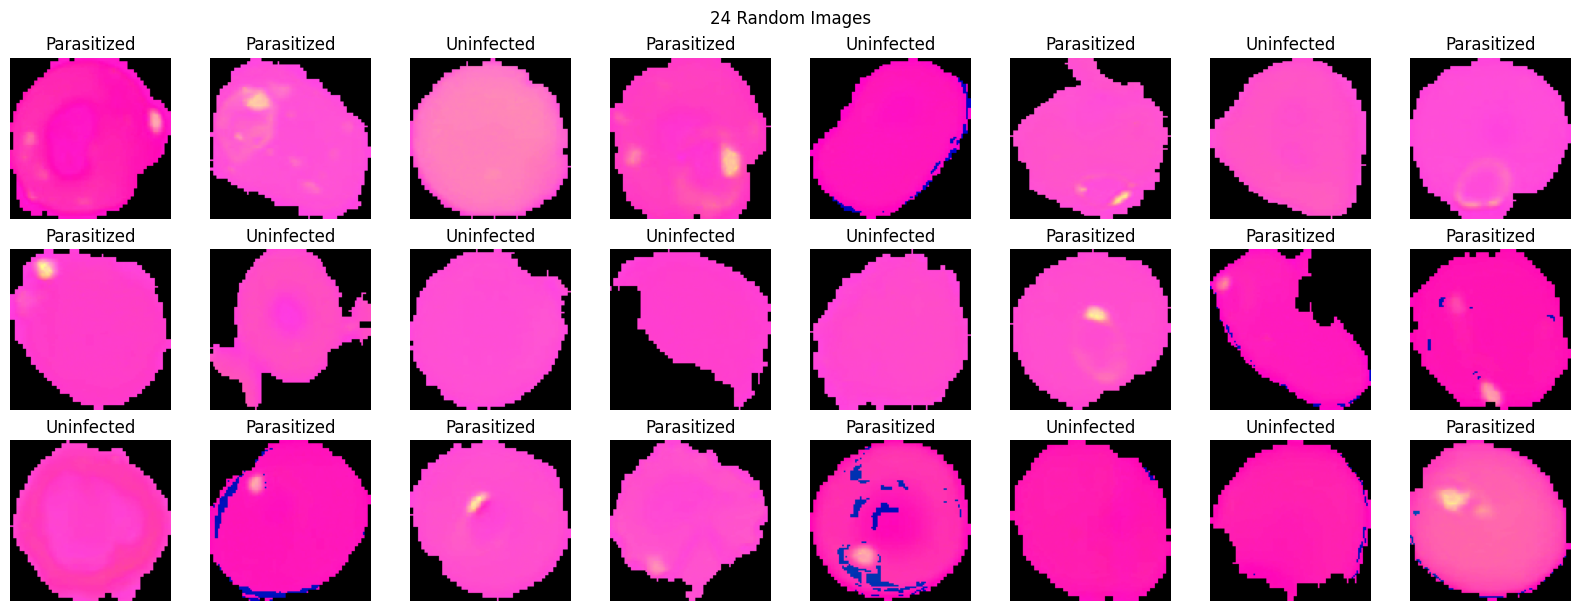

In [ ]:
plot_random_images(np.clip(HSV_train_images, 0, 1), train_labels)

###<b> Converting the test data

In [ ]:
# Convert from RBG (Red, Blue and Green) to HSV(Hue, Saturation and Value)
HSV_test_images = [cv2.cvtColor(image, cv2.COLOR_BGR2HSV) for image in X_train]

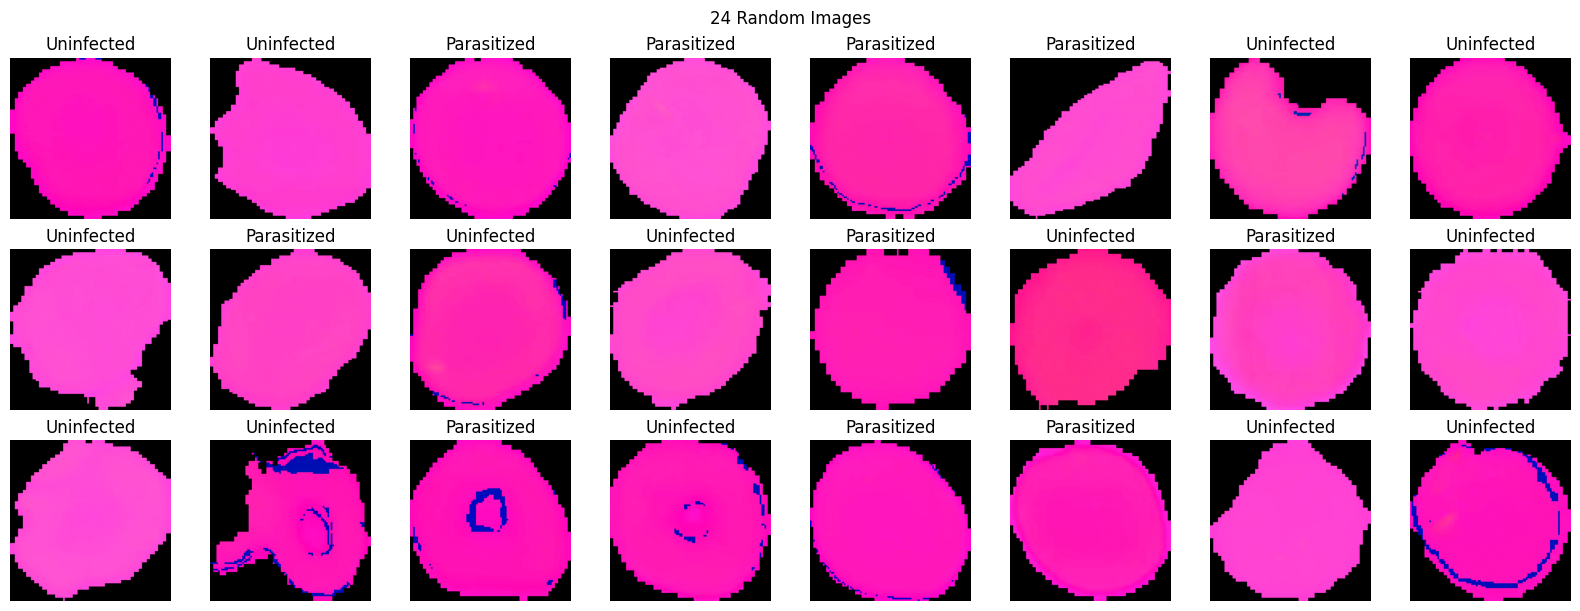

In [ ]:
plot_random_images(np.clip(HSV_test_images, 0, 1), test_labels)

####<b>Observations and insights:</b>
* The cells are of a uniform pink colour (in contrast to the different coloured RGB cells)
* We have blue masses or lines in some images for both classes of cells
* There are bright yellow spots in some images
* The HSV (Hue, Saturation and Value) model is based on how colours are presumably conceptualized in human vision and strives to be more intuitive for human and computer vision. This is known to improve readability, particularly in areas such as medical imaging where colour is not necessarily a factor

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

In [ ]:
# Preform a Gaussion Blur on the training images to sharpen edges
Gaussian_train_images = [cv2.GaussianBlur(image, (7, 7), 0) for image in X_train]

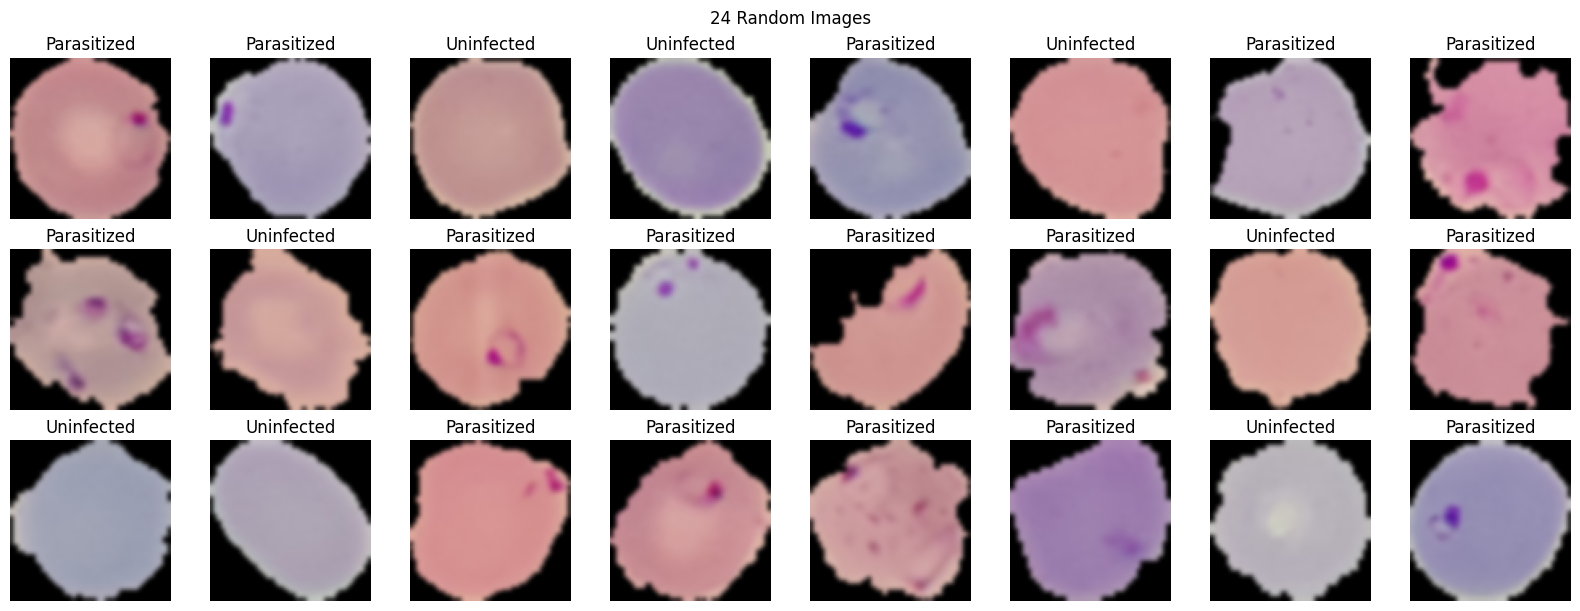

In [ ]:
plot_random_images(Gaussian_train_images, train_labels)

###<b> Gaussian Blurring on test data

In [ ]:
# Preform a Gaussion Blur on the test images
Gaussian_test_images = [cv2.GaussianBlur(image, (7, 7), 0) for image in X_test]

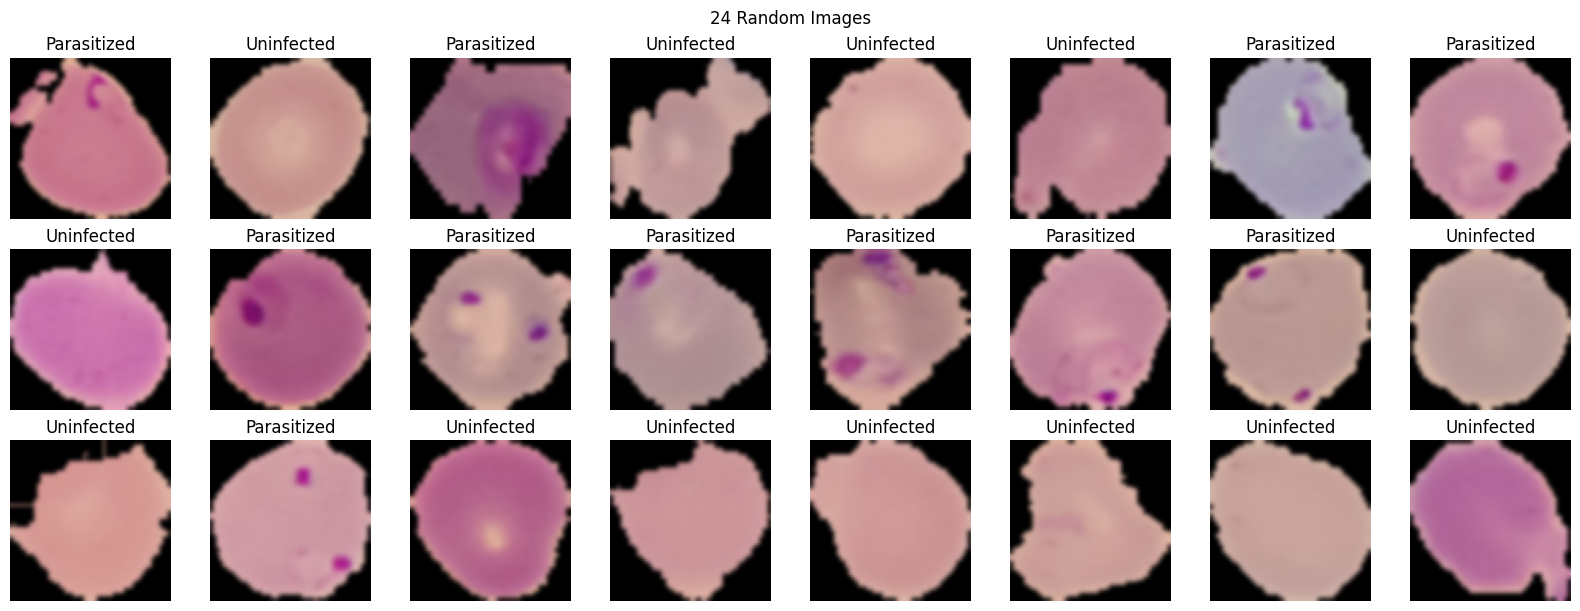

In [ ]:
plot_random_images(Gaussian_test_images, test_labels)

#### **Observations and insights:**

**Think About It:** Would blurring help us for this problem statement in any way? What else can we try?
* Gaussian Blurring is generally used in noisy images to help with edge detection
* The images in our data set are not noisy or pixilated and would likely not benefit from the application of Gaussian Blurring
* We can try other methods of edge detection more suited to medical images such Sobel, Prewitt, Roberts.
* Canny has proved effective in medical imaging [4]


[4] [A Comparative Study Of Edge Detection Technique With
MRI Images](https://www.webology.org/data-cms/articles/20220212114026amwebology%2019%20(1)%20-%2071.pdf)

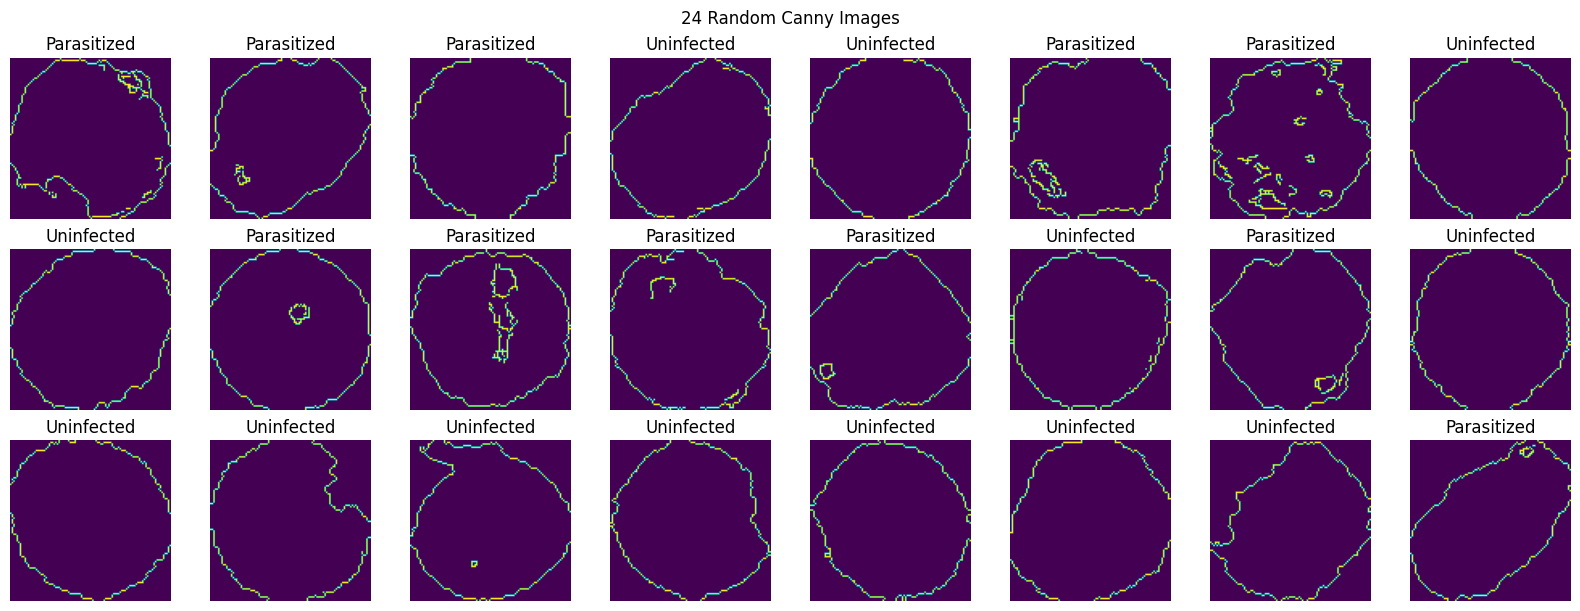

In [ ]:
# Apply Canny filter
def rgb_to_canny(rgb_images):
    canny_images = []
    for rgb_image in rgb_images:
        # Convert RGB image to grayscale
        gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)

        # Normalize the grayscale image
        normalized_gray_image = cv2.normalize(gray_image, None, 0, 255, cv2.NORM_MINMAX)

        # Convert the normalized grayscale image to 8-bit unsigned integer
        normalized_gray_image_uint8 = normalized_gray_image.astype(np.uint8)

        # Apply Canny edge detector
        edges = cv2.Canny(normalized_gray_image_uint8, threshold1=100, threshold2=200)  # Adjust thresholds as needed

        # Append Canny edge image to list
        canny_images.append(edges)

    return canny_images

# Plot Canny Images
canny_images = rgb_to_canny(X_train)
plot_random_images(canny_images, train_labels, title_extra='Canny ')

##### **Observations:**
* These images are uniform in color and parasitized images have a clear demarcated edge

## **Model Building**

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

###<b> Importing the required libraries for building and training our Model

In [ ]:
# Importing Deep Learning Libraries
import tensorflow as tf

from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, LeakyReLU, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Monitor model time
import time

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Create a function to set the seed and clear the backend between sessions
def reset_session(seed=42):
    backend.clear_session()
    np.random.seed(seed)
    import random
    random.seed(seed)
    tf.random.set_seed(seed)
    print(f"The session has been cleared. The random seed is set to {np.random.get_state()[1][0]}")

In [ ]:
reset_session()

The session has been cleared. The random seed is set to 42


####<B>One Hot Encoding the train and test labels

In [ ]:
# Current labels for y
labels = ['uninfected', 'parasitized',]

# Convert the labels to integers (use the index in a labels array)
integer_encoded_train = [labels.index(x) for x in train_labels]
integer_encoded_test = [labels.index(x) for x in test_labels]

# One-hot encode the integer labels
y_train = to_categorical(integer_encoded_train,2)
y_test = to_categorical(integer_encoded_test,2)

###<b> Building the model

In [ ]:
# Create a base CNN model
def base_model():
  # Creating sequential model
  model = Sequential()
  model.add(Input(shape=(picture_size, picture_size, 3)))

  # Convolutional Block 1
  model.add(Conv2D(64, (3,3), activation = "relu",  padding = 'same'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.4))

  # Convolutional Block 2
  model.add(Conv2D(32, (3,3), activation = "relu", padding = "same", ))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.4))

  # Flatten
  model.add(Flatten())

  # Fully Connected Layer 1
  model.add(Dense(128))
  model.add(Dropout(0.4))

  # Classifier
  model.add(Dense(2, activation = "softmax"))

  return model

In [ ]:
model = base_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,560,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,580,642 (9.84 MB)

 Trainable params: 2,580,642 (9.84 MB)

 Non-trainable params: 0 (0.00 B)

###<b> Compiling the model

In [ ]:
model.compile(optimizer = optimizers.Adam(learning_rate=.001), loss ='binary_crossentropy', metrics = ['accuracy'])

<b> Using Callbacks

In [ ]:
# Set the callbacks
callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 2, patience = 5),
             ModelCheckpoint('best_model.keras', monitor = 'val_loss', mode = 'min', verbose = 2, save_best_only = True)]

<b> Fit and train our Model

In [ ]:
# Record the time taken to train the model
start_time = time.time()

history = model.fit(X_train, y_train, validation_split=0.2, batch_size = 128, callbacks = callbacks, epochs = 20, verbose = 2)

# Record and print the time taken
end_time = time.time()
total_time = end_time - start_time
print (f"The model took {total_time:.2f} seconds to train")

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.66520, saving model to best_model.keras
156/156 - 23s - 150ms/step - accuracy: 0.6206 - loss: 0.7044 - val_accuracy: 0.6284 - val_loss: 0.6652
Epoch 2/20

Epoch 2: val_loss improved from 0.66520 to 0.60432, saving model to best_model.keras
156/156 - 6s - 39ms/step - accuracy: 0.6495 - loss: 0.6218 - val_accuracy: 0.7304 - val_loss: 0.6043
Epoch 3/20

Epoch 3: val_loss improved from 0.60432 to 0.41672, saving model to best_model.keras
156/156 - 6s - 39ms/step - accuracy: 0.7777 - loss: 0.4976 - val_accuracy: 0.7414 - val_loss: 0.4167
Epoch 4/20

Epoch 4: val_loss did not improve from 0.41672
156/156 - 6s - 38ms/step - accuracy: 0.8996 - loss: 0.3031 - val_accuracy: 0.7650 - val_loss: 0.4485
Epoch 5/20

Epoch 5: val_loss improved from 0.41672 to 0.34504, saving model to best_model.keras
156/156 - 6s - 39ms/step - accuracy: 0.9173 - loss: 0.2589 - val_accuracy: 0.8165 - val_loss: 0.3450
Epoch 6/20

Epoch 6: val_loss did not improve from

###<b> Evaluating the model on test data

In [ ]:
# Make predicitions on Test based on model
test_pred = np.argmax(model.predict(X_test), axis=-1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


<b> Plotting the confusion matrix

In [ ]:
# Create a function to print out the confusion matrix
def metrics_score(actual, predicted):
    '''Create heatmap plot for the confusion matrix'''
    # Show precision, recall and f1-score
    print(classification_report(actual, predicted))

    # Create confusion matrix
    cm = confusion_matrix(actual, predicted)

    # Calculate count and percentage
    cm_sum = [sum(row) for row in cm]
    cm_perc = [[(cell / row_sum * 100) for cell in row] for row, row_sum in zip(cm, cm_sum)]

    # Annote each cell with count and percentage
    annot = [[f"Count: {cm[i][j]}\n Percentage: {cm_perc[i][j]:.1f}%" for j in range(2)] for i in range(2)]

    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=annot, fmt='', xticklabels = labels, yticklabels = labels, cmap='coolwarm', cbar=False)
    plt.title('Confusion Matrix with Counts and Percentages')

    # Label the axes
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

              precision    recall  f1-score   support

           0       0.87      0.99      0.92      1300
           1       0.99      0.85      0.91      1300

    accuracy                           0.92      2600
   macro avg       0.93      0.92      0.92      2600
weighted avg       0.93      0.92      0.92      2600



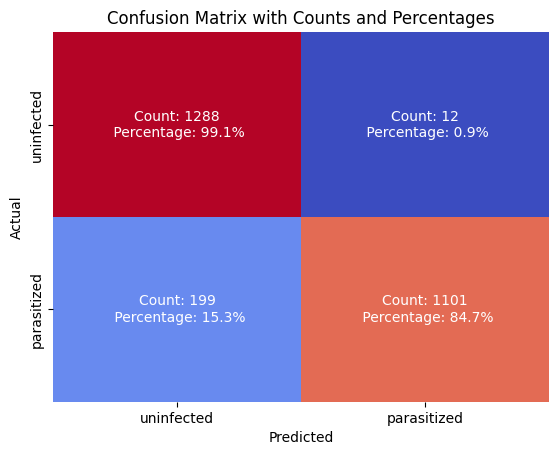

In [ ]:
metrics_score(integer_encoded_test, test_pred)

<b>Plotting the train and validation curves

In [ ]:
def plot_train_val_accuracy(model, title='Model Accuracy'):
    plt.figure(figsize=(10,6))
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(np.arange(0, len(model.history['accuracy'])+1, 1))
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()

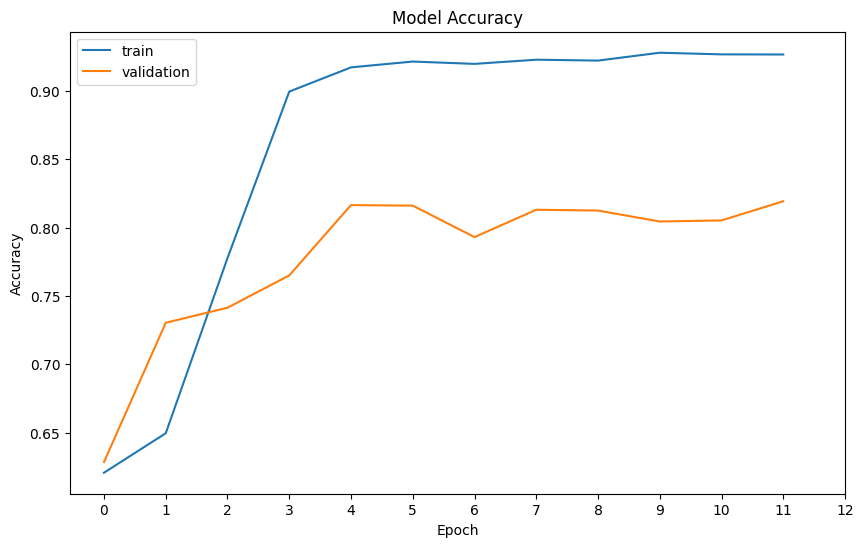

In [ ]:
plot_train_val_accuracy(history)

In [ ]:
def plot_random_correct(test_labels,images, test_pred):
  # Randomly select 24 correctly classified images from the Test set and visualize them - see where our model is preforming well
  random_indicies = []
  # Take 24 random integers where the images are classified correctly
  while len(random_indicies) < 24:
    i = np.random.randint(0, len(test_labels))
    true_label = test_labels[i]
    # Compare real lable to predicted label (as in index in the labels array)
    pred_label = labels[test_pred[i]]
    if pred_label == true_label:
      random_indicies.append(i)

  # Create the plot
  fig, axs = plt.subplots(nrows=3, ncols=8,figsize=(16, 7))
  axs = axs.flat

  # Display each Test image with it's
  for ax in axs:
      j = axs.index -1
      ax.imshow(images[random_indicies[j]], cmap='gray')
      ax.set_title(f"{test_labels[random_indicies[j]].capitalize()}")
      ax.axis('off')

  fig.suptitle('24 Random Correctly Categorized Test Images')
  plt.show()

In [ ]:
def plot_random_incorrect(test_labels, images, test_pred):

  # Randomly select 24 incorrectly classified images from the Test set and visualize them - see where our model is preforming poorly
  random_indicies = []
  # Take 24 random integers where the images are misclassified
  while len(random_indicies) < 24:
    i = np.random.randint(0, len(test_labels))
    true_label = test_labels[i]
    # Compare real lable to predicted label (as in index in the labels array)
    pred_label = labels[test_pred[i]]
    if pred_label != true_label:
      random_indicies.append(i)

  # Create the plot
  fig, axs = plt.subplots(nrows=3, ncols=8,figsize=(16, 6))
  axs = axs.flat

  # Display each Test image with it's actual value, predicated value and confidence
  for ax in axs:
      i = axs.index -1
      ax.imshow(images[random_indicies[i]], cmap='gray')
      ax.set_title(f"{test_labels[random_indicies[i]].capitalize()}", color='red')
      ax.axis('off')

  fig.suptitle('24 Random Incorrectly Categorized Test Images (True Label)')
  plt.show()

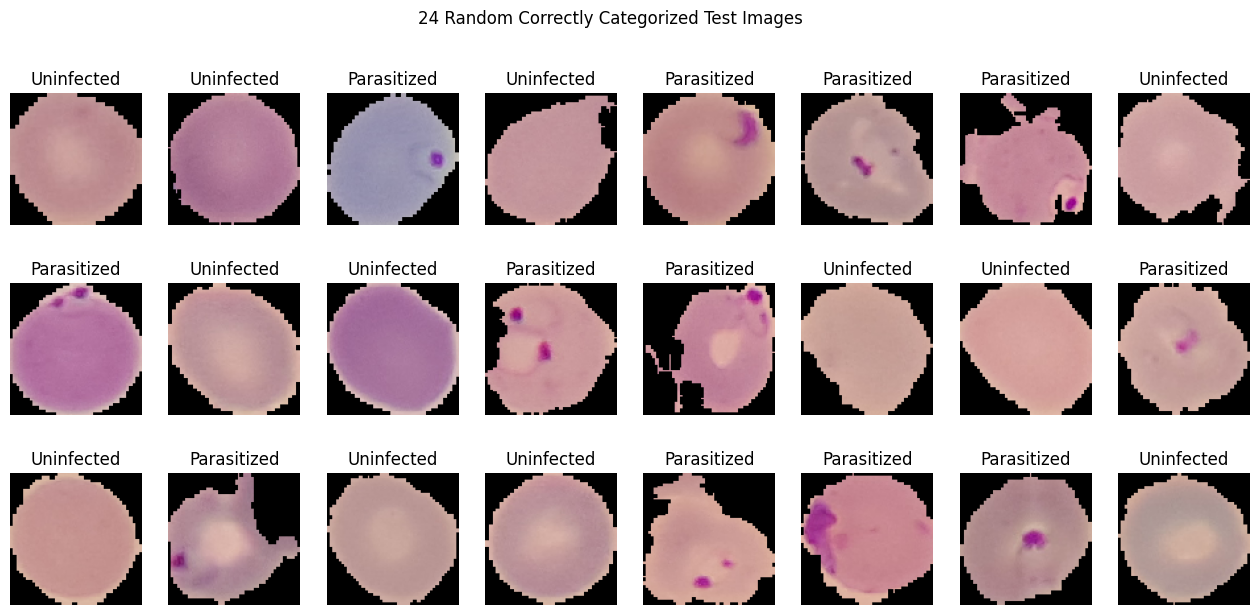

In [ ]:
plot_random_correct(test_labels, X_test, test_pred)

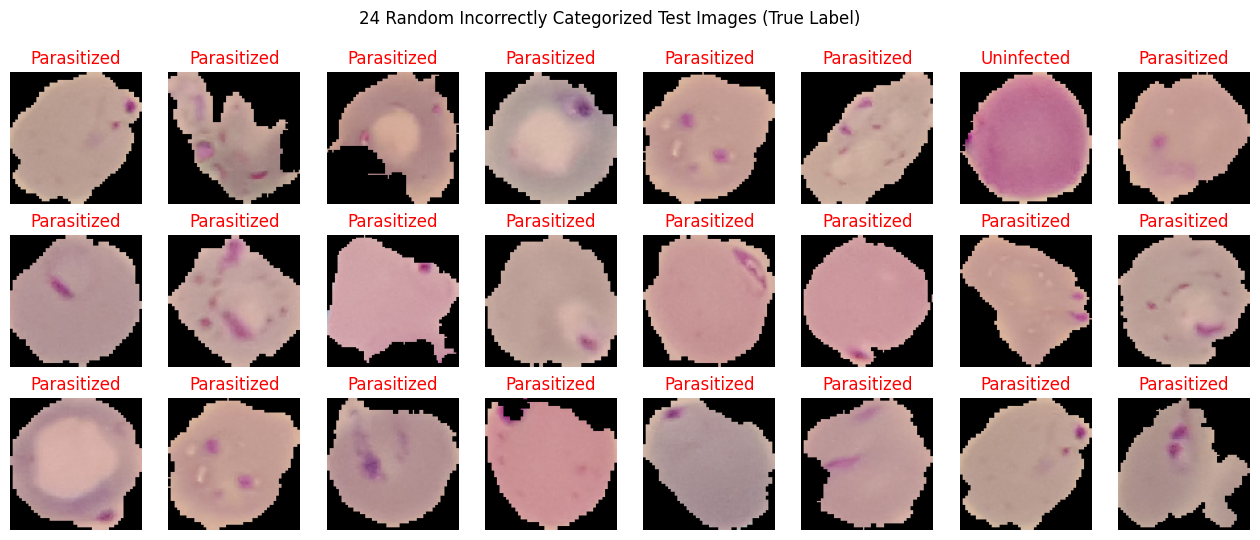

In [ ]:
plot_random_incorrect(test_labels, X_test, test_pred)

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

**Observations:**
* We created a base model with:
  * 2 Convolutional Layers
  * 1 Fully-Connected Dense layer
  * 2,580,642 trainable parameters
* The model was compiled with the Adam optimers and a learnig rate of 0.001
* The model ran over 20 epochs with a batch size of 128 employing EarlyStopping and ModelCheckpoint callbacks

* We have a relatively steady increase in our training and validation data
* There some overfitting on the training data but not too much noise
* The model correctly indentified 99.1% of ininfected images but had issues with misclasifying parasitized images

* The randomly sampled incorrect images shows that our model struggles with purple cells with small parasites
Let's see if we can improve our model with more layers

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


###<b> Building the Model

In [ ]:
reset_session()

The session has been cleared. The random seed is set to 42


In [ ]:
# Create a basic CNN model
def model1():
  # Creating sequential model
  model = Sequential()
  model.add(Input(shape=(picture_size, picture_size, 3)))

  # Convolutional Block 1
  model.add(Conv2D(64, (3,3), activation = "relu",  padding = 'same'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.2))

  # Convolutional Block 2
  model.add(Conv2D(32, (3,3), activation = "relu", padding = "same", ))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.2))

  # Convolutional Block 3
  model.add(Conv2D(32, (3,3), activation = "relu", padding = "same", ))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.2))

  # Convolutional Block 4
  model.add(Conv2D(32, (3,3), activation = "relu", padding = "same", ))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.2))

  # Flatten
  model.add(Flatten())

  # Fully Connected Layer 1
  model.add(Dense(124))
  model.add(Dropout(0.4))

  # Fully Connected Layer 2
  model.add(Dense(124))
  model.add(Dropout(0.4))

  # Classifier
  model.add(Dense(2, activation = "softmax"))

  return model

In [ ]:
model1 = model1()
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 124)                 │         142,972 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 124)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 124)                 │          15,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 124)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,474 (771.38 KB)

 Trainable params: 197,474 (771.38 KB)

 Non-trainable params: 0 (0.00 B)

###<b> Compiling the model

In [ ]:
model1.compile(optimizer = optimizers.Adam(learning_rate=.001), loss ='binary_crossentropy', metrics = ['accuracy'])

<b> Using Callbacks

In [ ]:
# Use the same callbacks as the original model

<b>Fit and Train the model

In [ ]:
# Record the time taken to train the model
start_time = time.time()

history1 = model1.fit(X_train, y_train, validation_split=0.2, batch_size = 128, callbacks = callbacks, epochs = 20, verbose = 2)

# Record and print the time taken
end_time = time.time()
total_time1 = end_time - start_time
print (f"Model 1 took {total_time1:.2f} seconds to train")

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.77813, saving model to best_model.keras
156/156 - 26s - 169ms/step - accuracy: 0.6392 - loss: 0.6426 - val_accuracy: 0.3055 - val_loss: 0.7781
Epoch 2/20

Epoch 2: val_loss improved from 0.77813 to 0.38959, saving model to best_model.keras
156/156 - 7s - 43ms/step - accuracy: 0.9032 - loss: 0.2610 - val_accuracy: 0.8578 - val_loss: 0.3896
Epoch 3/20

Epoch 3: val_loss improved from 0.38959 to 0.18620, saving model to best_model.keras
156/156 - 7s - 43ms/step - accuracy: 0.9646 - loss: 0.1226 - val_accuracy: 0.9383 - val_loss: 0.1862
Epoch 4/20

Epoch 4: val_loss improved from 0.18620 to 0.13374, saving model to best_model.keras
156/156 - 7s - 43ms/step - accuracy: 0.9722 - loss: 0.0929 - val_accuracy: 0.9527 - val_loss: 0.1337
Epoch 5/20

Epoch 5: val_loss improved from 0.13374 to 0.10330, saving model to best_model.keras
156/156 - 7s - 42ms/step - accuracy: 0.9755 - loss: 0.0828 - val_accuracy: 0.9617 - val_loss: 0.1033
Epoch 6/20



###<b> Evaluating the model

In [ ]:
# Make predicitions on Test based on model
test_pred1 = np.argmax(model1.predict(X_test), axis=-1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1300
           1       0.99      0.96      0.97      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



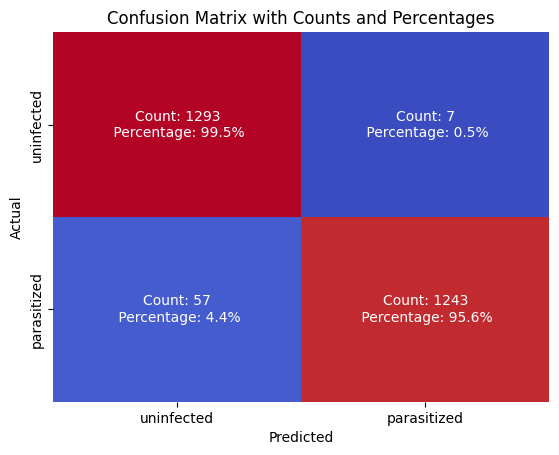

In [ ]:
# Print out the classification report and confusion matrix of the model
metrics_score(integer_encoded_test, test_pred1)

<b> Plotting the train and the validation curves

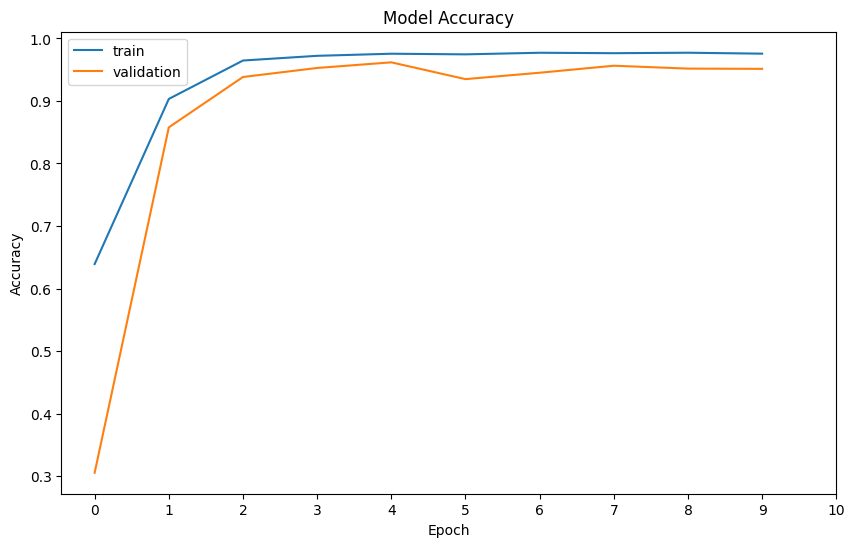

In [ ]:
plot_train_val_accuracy(history1)

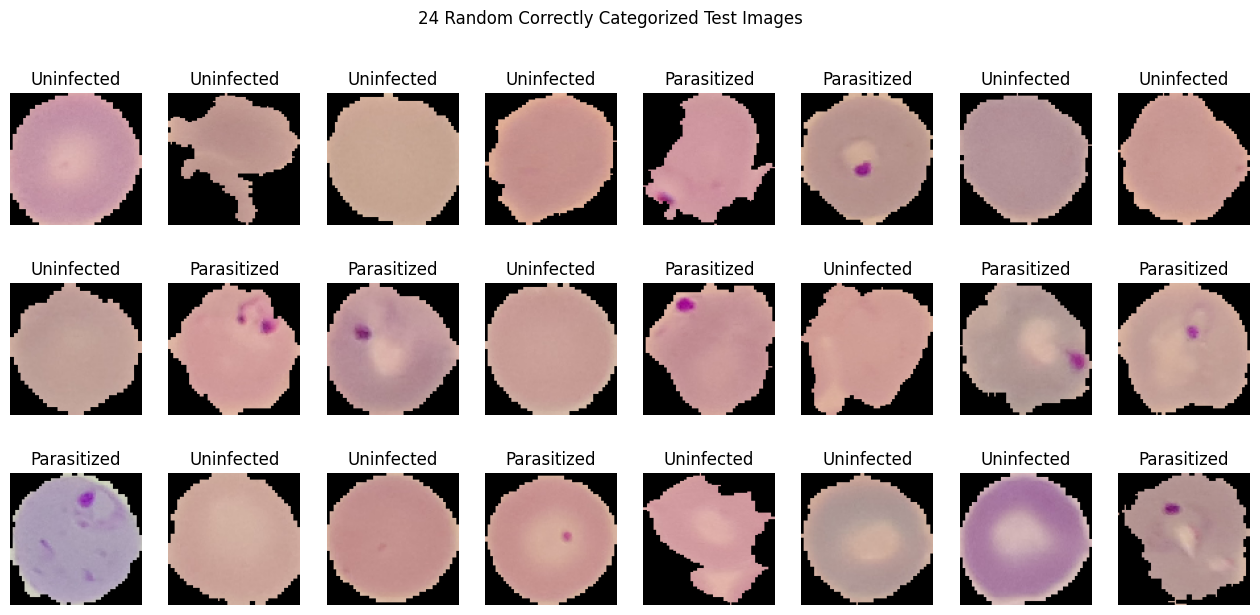

In [ ]:
plot_random_correct(test_labels, X_test, test_pred1)

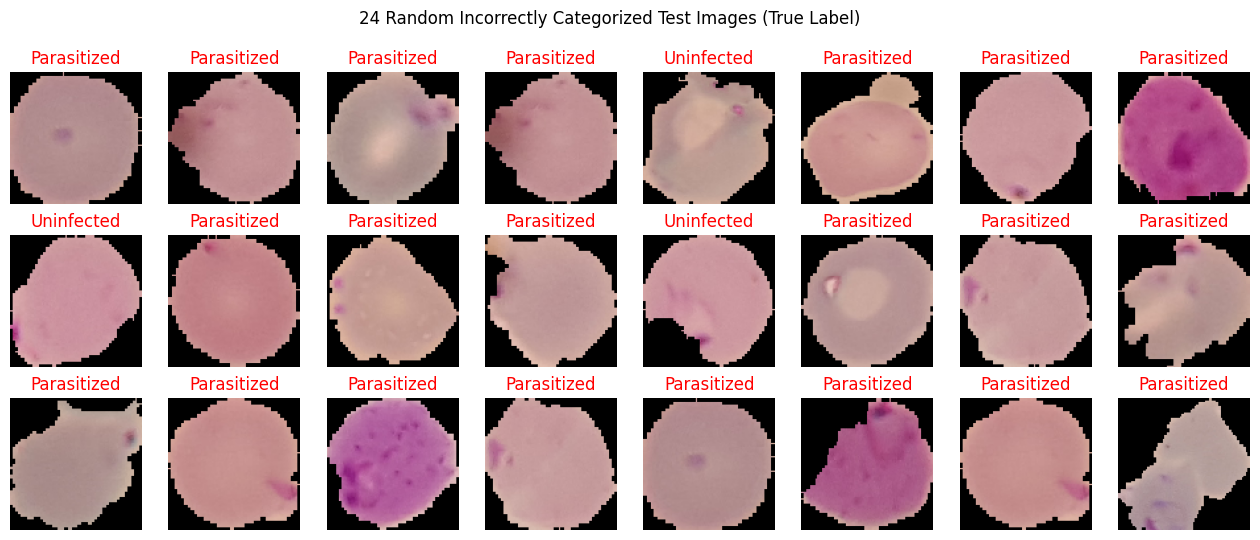

In [ ]:
plot_random_incorrect(test_labels, X_test, test_pred1)

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

#### <b>Observations:
* We decreased our parameters to 197,474
* Improved our overfitting
* Improved our detection of parasitized images for a more balanced model
* Increased our overall accuracy, precision and recall to 98%

A nice improvement with the addition of more layers and more dropout layers

###<b> Model 2 with Batch Normalization

In [ ]:
reset_session()

The session has been cleared. The random seed is set to 42


In [ ]:
def batch_leaky_relu():
# Creating sequential model
  model = Sequential()
  model.add(Input(shape=(picture_size, picture_size, 3)))

  # Convolutional Block 1
  model.add(Conv2D(64, (3,3),  padding = "same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.2))

  # Convolutional Block 2
  model.add(Conv2D(32, (3,3),  padding = "same"))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.2))

  # Convolutional Block 3
  model.add(Conv2D(32, (3,3),  padding = "same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.2))

  # Convolutional Block 4
  model.add(Conv2D(32, (3,3),  padding = "same"))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.2))

  # Flatten
  model.add(Flatten())

  # Fully Connected Layer 1
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.4))

  # Batch Normalization Layer
  model.add(BatchNormalization())

  # Classifier
  model.add(Dense(2, activation = "softmax"))

  return model

###<b> Building the Model

In [ ]:
model2 = batch_leaky_relu()
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 100, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 25, 25, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 335,842 (1.28 MB)

 Trainable params: 335,138 (1.28 MB)

 Non-trainable params: 704 (2.75 KB)

###<b>Compiling the model

In [ ]:
model2.compile(optimizer = optimizers.Adam(learning_rate=.001), loss ='binary_crossentropy', metrics = ['accuracy'])

<b> Using callbacks

<b>Fit and train the model

In [ ]:
# Record the time taken to train the model
start_time = time.time()

history2 = model2.fit(X_train, y_train, validation_split=0.2, batch_size = 64, callbacks = callbacks, epochs = 20, verbose = 2)

# Record and print the time taken
end_time = time.time()
total_time2 = end_time - start_time
print (f"Model 2 took {total_time2:.2f} seconds to train")

Epoch 1/20

Epoch 1: val_loss did not improve from 0.10330
312/312 - 31s - 101ms/step - accuracy: 0.8026 - loss: 0.4177 - val_accuracy: 0.1605 - val_loss: 1.2179
Epoch 2/20

Epoch 2: val_loss did not improve from 0.10330
312/312 - 9s - 29ms/step - accuracy: 0.9720 - loss: 0.0839 - val_accuracy: 0.9417 - val_loss: 0.2210
Epoch 3/20

Epoch 3: val_loss did not improve from 0.10330
312/312 - 9s - 29ms/step - accuracy: 0.9755 - loss: 0.0732 - val_accuracy: 0.9505 - val_loss: 0.1519
Epoch 4/20

Epoch 4: val_loss did not improve from 0.10330
312/312 - 9s - 28ms/step - accuracy: 0.9789 - loss: 0.0627 - val_accuracy: 0.9539 - val_loss: 0.1702
Epoch 5/20

Epoch 5: val_loss did not improve from 0.10330
312/312 - 9s - 28ms/step - accuracy: 0.9798 - loss: 0.0609 - val_accuracy: 0.9499 - val_loss: 0.2162
Epoch 5: early stopping
Model 2 took 71.90 seconds to train


<b>Plotting the train and validation accuracy

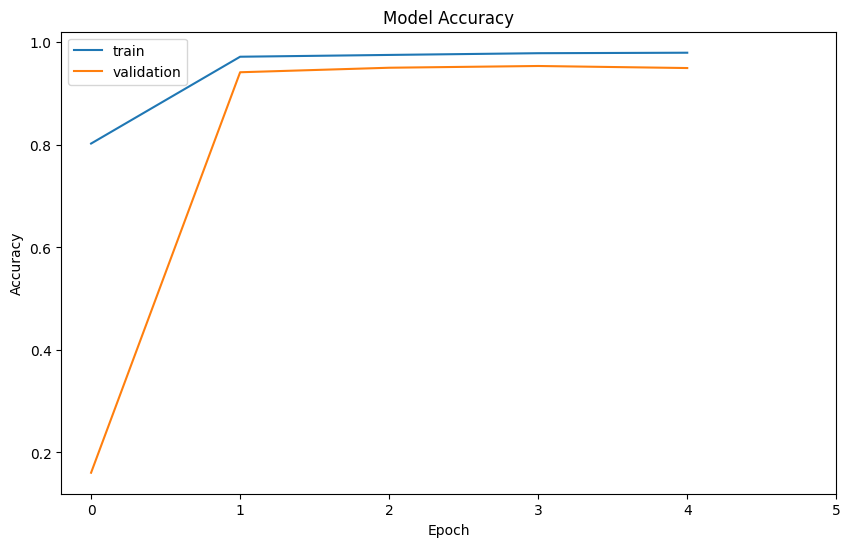

In [ ]:
plot_train_val_accuracy(history2)


###<b>Evaluating the model

In [ ]:
# Make predicitions on Test based on model
test_pred2 = np.argmax(model2.predict(X_test), axis=-1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


#### **Observations and insights:

* We added batch normalization layers to our second model and changed the activation function  Leaky ReLU
* Our training and validation curves increase rapidly to 98% and 95% accuarcy
* Our overall testing accuracy remains the same at 98% with a slight improvement in detecting malarial cells
* This model preforms quite well but is comprable to model 1

<b> Generate the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1300
           1       1.00      0.96      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



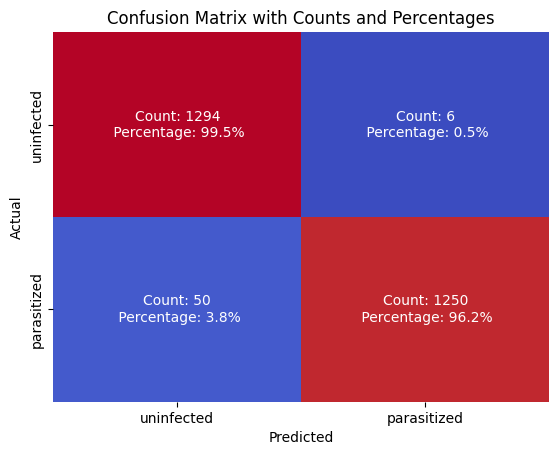

In [ ]:
metrics_score(integer_encoded_test, test_pred2)

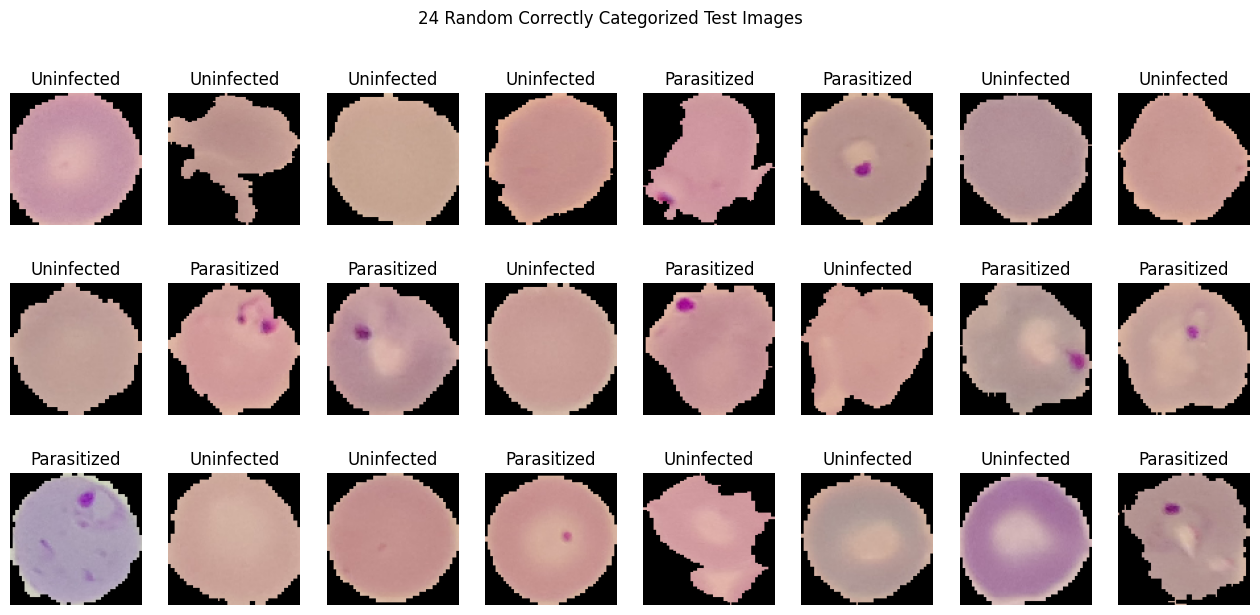

In [ ]:
plot_random_correct(test_labels, X_test, test_pred2)

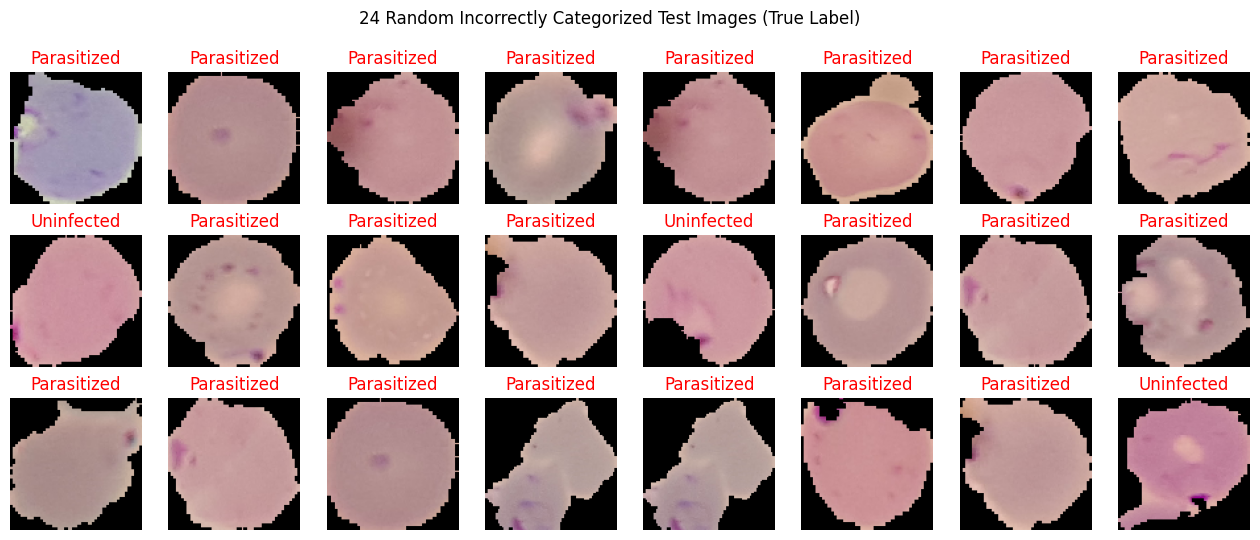

In [ ]:
plot_random_incorrect(test_labels, X_test, test_pred2)

There appears to be more variation in our misidentified images

###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

###<b> Use image data generator

In [ ]:
datagen = ImageDataGenerator(
    rotation_range = 45,
    zoom_range = 0.2,
    shear_range = 0.2,
)

X_train_augmented, X_val_augmented, y_train_augmented, y_val_augmented = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

train_set = datagen.flow(x = X_train_augmented, y = y_train_augmented, batch_size=64)
val_set = datagen.flow(x = X_val_augmented,y = y_val_augmented, batc_size=64)

###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

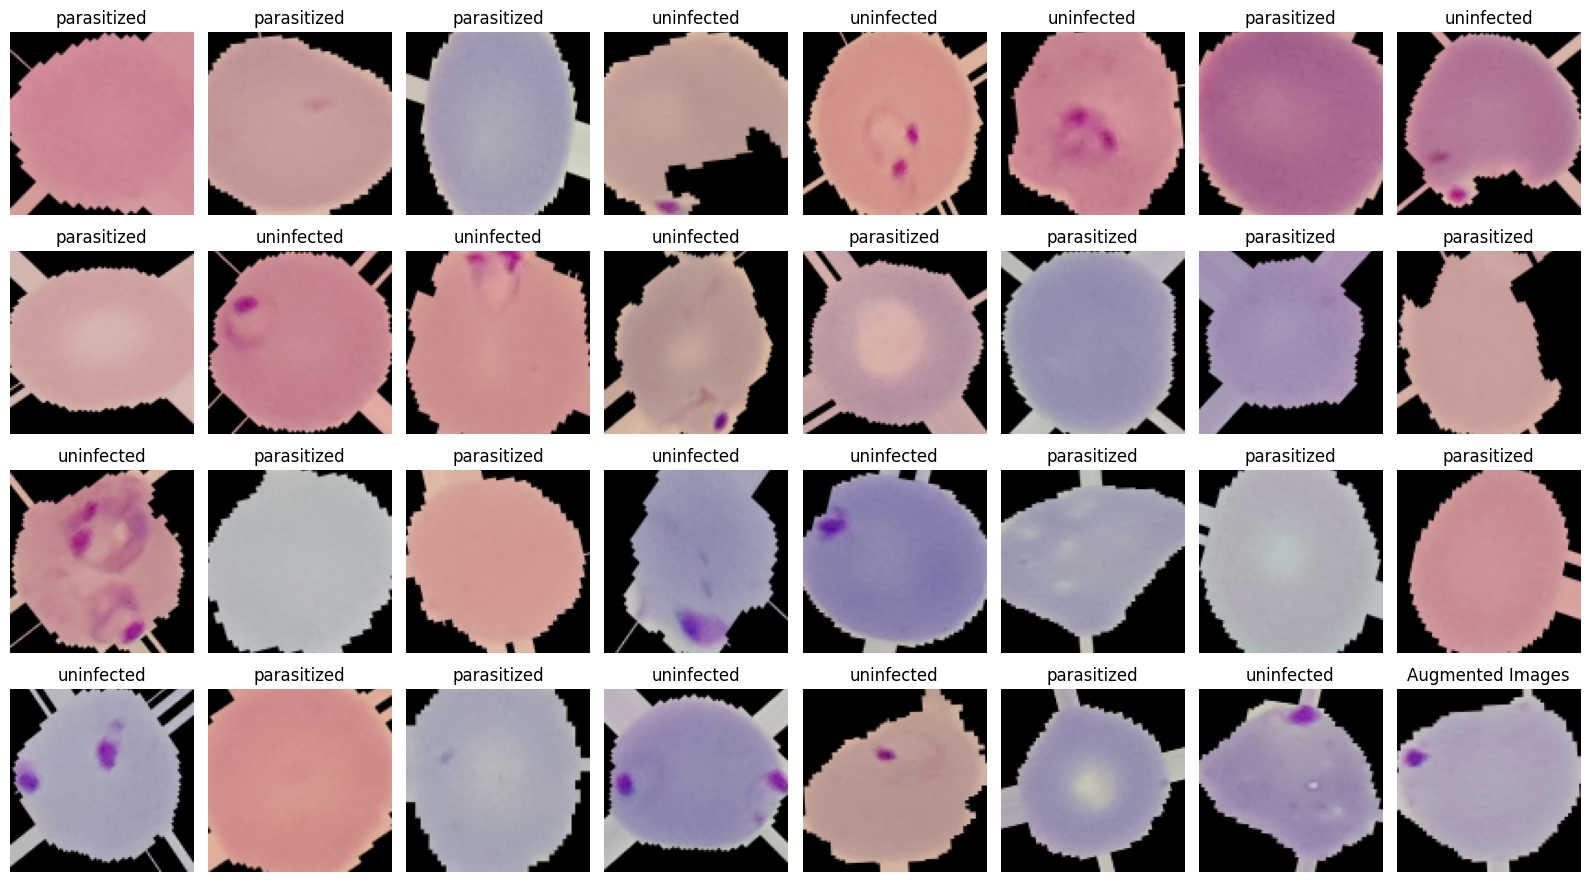

In [ ]:
# Get the first batch of images and labels
batch_images, batch_labels = next(train_set)

# plot images in default batch size = 32
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(16,9), tight_layout=True )
axs = axs.flat
# fig.set_size_inches(16, 8)
for ax in axs:
    i = axs.index -1
    ax.imshow(batch_images[i])
    ax.set_title(labels[int(batch_labels[i][0])])
    ax.axis('off')
    plt.title("Augmented Images")

plt.show()

####<b>Observations and insights:</b>
* We added three transformation to augment our dataset: rotation, zoom and flip
* The cells are now no longer always center in the image
* The image may be entirely composed of the cell
* The are striations protruding from the cells in some images


###<b>Building the Model

In [ ]:
reset_session()
# Load previous best model
# model3 = load_model('best_model.keras')
model3 = batch_leaky_relu()
model3.summary()
model3.compile(optimizer = optimizers.Adam(learning_rate=.001), loss ='binary_crossentropy', metrics = ['accuracy'])

The session has been cleared. The random seed is set to 42


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 100, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 25, 25, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 335,842 (1.28 MB)

 Trainable params: 335,138 (1.28 MB)

 Non-trainable params: 704 (2.75 KB)

<b>Using Callbacks

In [ ]:
# Same callbacks

<b> Fit and Train the model

In [ ]:
# Record the time taken to train the model
start_time = time.time()

history3 = model3.fit(X_train, y_train, validation_split=0.2, batch_size = 64, callbacks = callbacks, epochs = 20, verbose = 2)

# Record and print the time taken
end_time = time.time()
total_time3 = end_time - start_time
print (f"Model 3 took {total_time3:.2f} seconds to train")

Epoch 1/20

Epoch 1: val_loss did not improve from 0.09322
312/312 - 27s - 87ms/step - accuracy: 0.7983 - loss: 0.4272 - val_accuracy: 0.3095 - val_loss: 0.9998
Epoch 2/20

Epoch 2: val_loss did not improve from 0.09322
312/312 - 9s - 29ms/step - accuracy: 0.9726 - loss: 0.0831 - val_accuracy: 0.9397 - val_loss: 0.1596
Epoch 3/20

Epoch 3: val_loss did not improve from 0.09322
312/312 - 9s - 29ms/step - accuracy: 0.9757 - loss: 0.0706 - val_accuracy: 0.9521 - val_loss: 0.1341
Epoch 4/20

Epoch 4: val_loss did not improve from 0.09322
312/312 - 9s - 29ms/step - accuracy: 0.9786 - loss: 0.0630 - val_accuracy: 0.9407 - val_loss: 0.2544
Epoch 5/20

Epoch 5: val_loss did not improve from 0.09322
312/312 - 9s - 28ms/step - accuracy: 0.9771 - loss: 0.0626 - val_accuracy: 0.9521 - val_loss: 0.1385
Epoch 5: early stopping
Model 3 took 67.92 seconds to train


###<B>Evaluating the model

<b>Plot the train and validation accuracy

In [ ]:
# Make predicitions on Test based on model
test_pred3 = np.argmax(model3.predict(X_test), axis=-1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


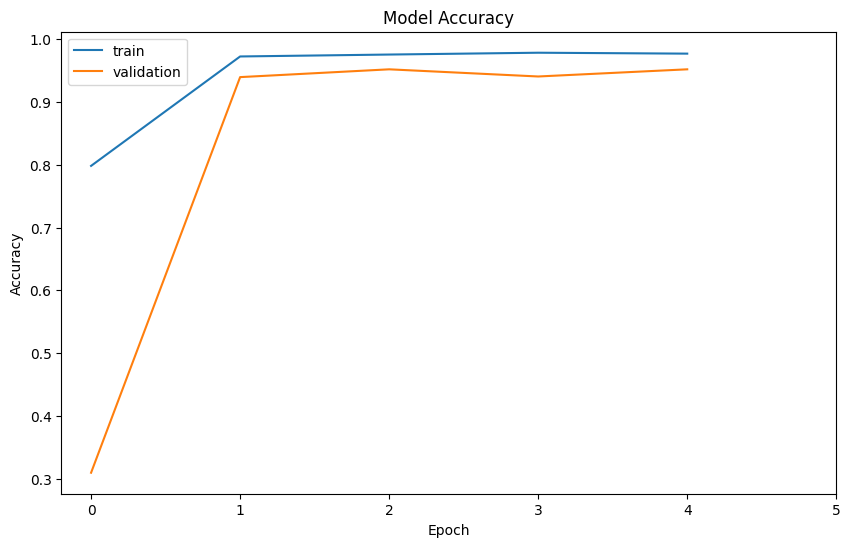

In [ ]:
plot_train_val_accuracy(history3)

<B>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1300
           1       1.00      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



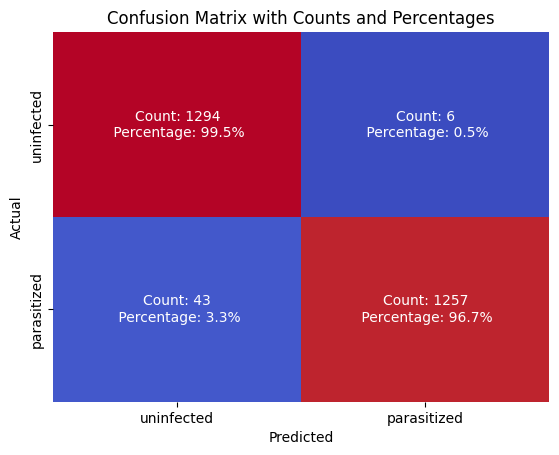

In [ ]:
metrics_score(integer_encoded_test, test_pred3)

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

* Since our test and training sets are both controled medical images this may not prove usefull in augmenting our training

### **Pre-trained model (VGG16)**
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16


In [ ]:
reset_session()

The session has been cleared. The random seed is set to 42


In [ ]:
vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (picture_size, picture_size, 3))
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
transfer_layer = vgg.get_layer('block5_pool')
# Making all the layers of the _base model non-trainable
for layer in vgg.layers:
    layer.trainable = False

# Flatten
x = Flatten()(transfer_layer.output)


# Fully Connected Layer
x = Dense(264, activation = 'relu')(x)
x = Dropout(0.4)(x)

# Batch Normalization Layer
x = BatchNormalization()(x)

# Classifier
pred = Dense(2, activation = 'softmax')(x)

# Initialize the model
model4 = Model(vgg.input, pred)

In [ ]:
model4.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 264)                 │       1,216,776 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,933,050 (60.78 MB)

 Trainable params: 1,217,834 (4.65 MB)

 Non-trainable params: 14,715,216 (56.13 MB)

###<b>Compiling the model

In [ ]:
model4.compile(optimizer = optimizers.Adam(learning_rate=.0005), loss ='binary_crossentropy', metrics = ['accuracy'])

<b> using callbacks

In [ ]:
# Same

<b>Fit and Train the model

In [ ]:
# Record the time taken to train the model
start_time = time.time()

history4 = model4.fit(X_train, y_train, validation_split=0.2, batch_size = 64, callbacks = callbacks, epochs = 20, verbose = 2)

# Record and print the time taken
end_time = time.time()
total_time4 = end_time - start_time
print (f"Model 4 took {total_time4:.2f} seconds to train")

Epoch 1/20

Epoch 1: val_loss did not improve from 0.09965
312/312 - 45s - 145ms/step - accuracy: 0.9352 - loss: 0.1977 - val_accuracy: 0.9323 - val_loss: 0.1585
Epoch 2/20

Epoch 2: val_loss did not improve from 0.09965
312/312 - 23s - 75ms/step - accuracy: 0.9551 - loss: 0.1387 - val_accuracy: 0.9215 - val_loss: 0.1714
Epoch 3/20

Epoch 3: val_loss did not improve from 0.09965
312/312 - 23s - 74ms/step - accuracy: 0.9573 - loss: 0.1302 - val_accuracy: 0.9289 - val_loss: 0.1608
Epoch 4/20

Epoch 4: val_loss did not improve from 0.09965
312/312 - 24s - 76ms/step - accuracy: 0.9599 - loss: 0.1226 - val_accuracy: 0.9044 - val_loss: 0.2202
Epoch 5/20

Epoch 5: val_loss did not improve from 0.09965
312/312 - 24s - 76ms/step - accuracy: 0.9610 - loss: 0.1189 - val_accuracy: 0.9347 - val_loss: 0.1544
Epoch 5: early stopping
Model 4 took 144.11 seconds to train


<b>Plot the train and validation accuracy

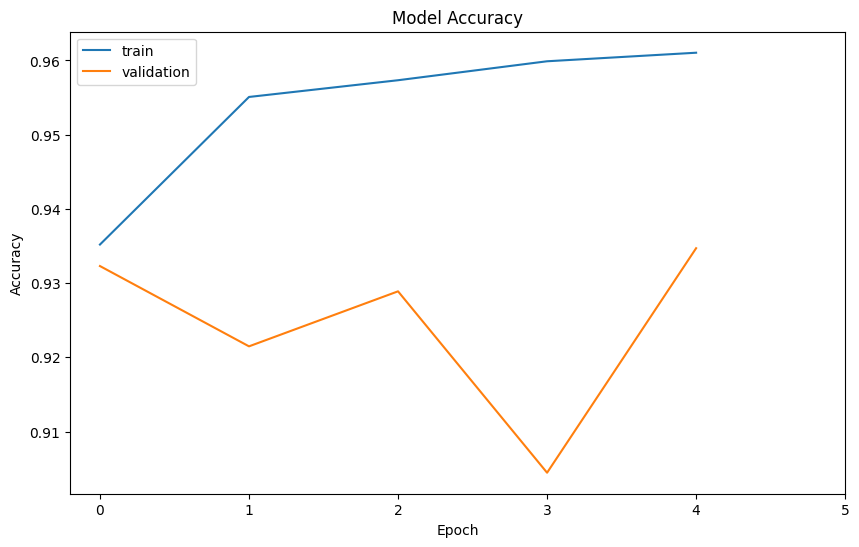

In [ ]:
plot_train_val_accuracy(history4)

###**Observations and insights:**

*   What can be observed from the validation and train curves?


###<b> Evaluating the model

In [ ]:
# Make predicitions on Test based on model4
test_pred4 = np.argmax(model4.predict(X_test), axis=-1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step


<b>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1300
           1       0.98      0.95      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600



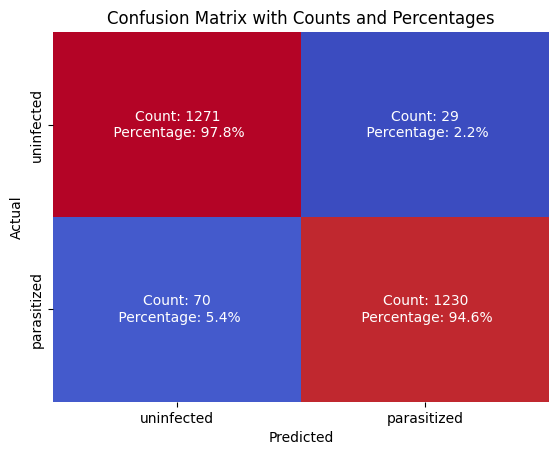

In [ ]:
metrics_score(integer_encoded_test, test_pred4)

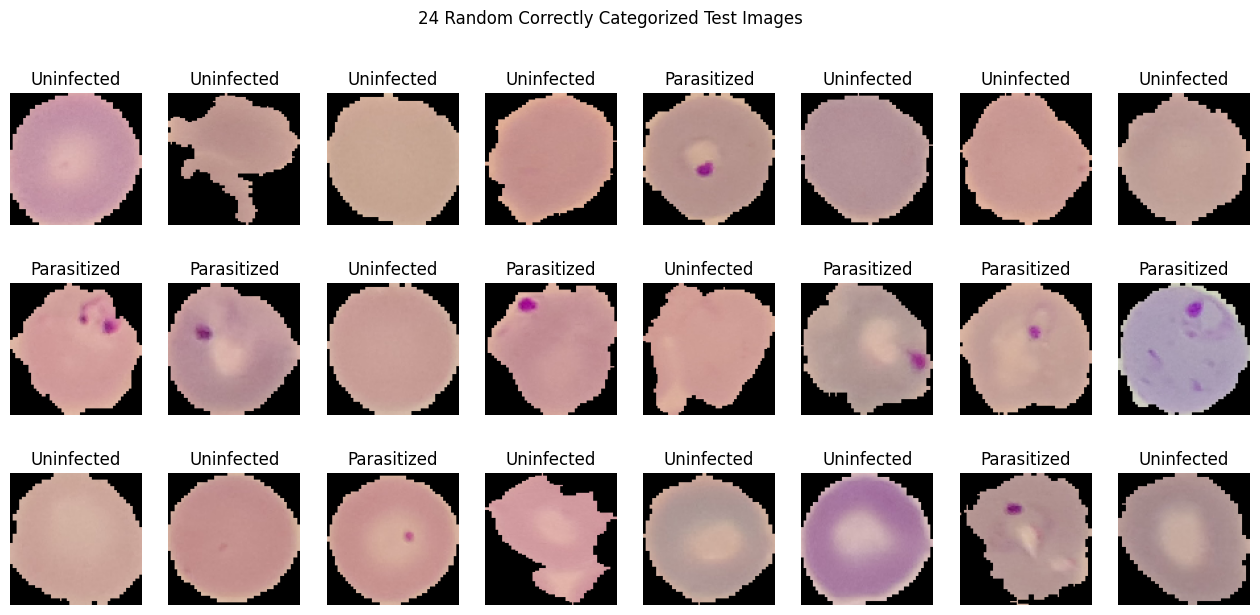

In [ ]:
plot_random_correct(test_labels, X_test, test_pred4)

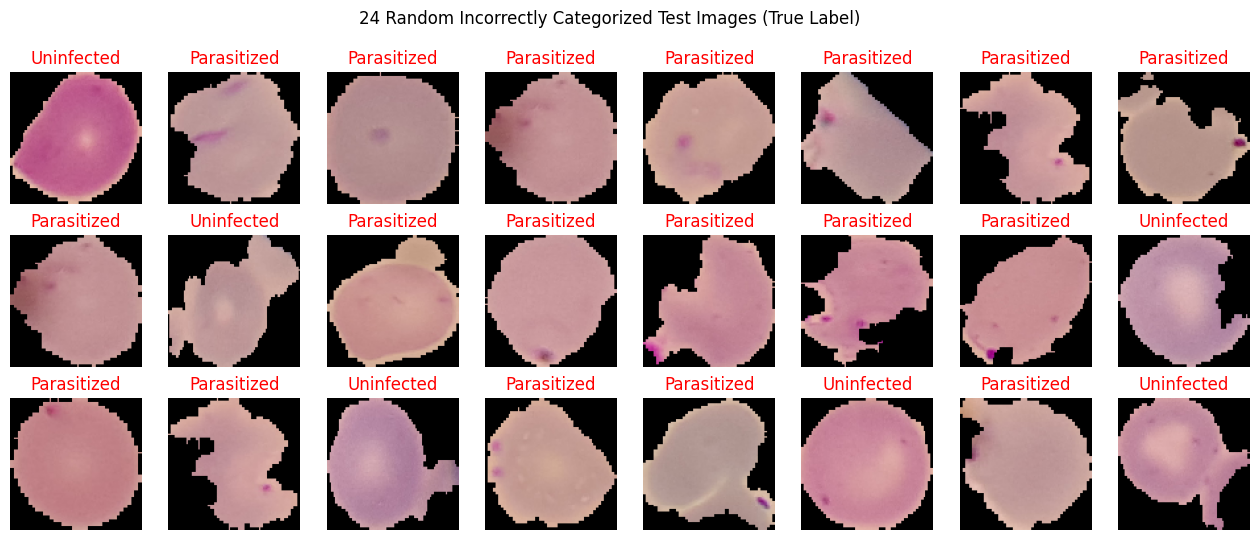

In [ ]:
plot_random_incorrect(test_labels, X_test, test_pred4)

### <b> Oberservations:
* Model 4 is by far the largest and has a significantly reduced accuarcy from the other models

###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


In [ ]:
for model_name, model in zip(["Model 1", "Model 2", "Model3", "Model4"],[model1, model2, model3, model4]):
  test_loss, test_accuracy = model.evaluate(X_test, y_test)
  print(f"{model_name} Test Accuracy: {test_accuracy:.3f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9894 - loss: 0.0417
Model 1 Test Accuracy: 0.975
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9908 - loss: 0.0380
Model 2 Test Accuracy: 0.978
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9913 - loss: 0.0352
Model3 Test Accuracy: 0.981
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9724 - loss: 0.1033
Model4 Test Accuracy: 0.962


In [ ]:
# Save model3 as the final model
final_model = model3
final_model.save('final_model.keras')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 100, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 25, 25, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,006,120 (3.84 MB)

 Trainable params: 335,138 (1.28 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 670,278 (2.56 MB)

####<b> Observations and Conclusions drawn from the final model:</b>
* The classification reports and confusion matrices indicate strong results for our models
* The 3 trained CNN models all have an accuracy of 98%
* Model 4 had the poorest performance and most complexity
* All models struggled with False Negatives but excelled at minimizing False Positives for malaria

Final Model
* We save model 3 - the data-augmented model with batch normalization and Leaky ReLU as the best model (note this did not have the lowest val_loss so it was not saved in the best_model.keras file)
* Model 3 had 98. 1% accuracy and accurately predicted uninfected cells(99.5%) and parasitized cells(96.7%) with 335,138 trainable parameters






**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?


*  You can try to build a model using these HSV images and compare them with your other models.

#### **Insights**

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

Malaria detection proves to be an interesting and rewarding challenge for computer vision.
We must detect the presence of parasites while ignoring other abnormalities that can be present in a human cell, or those resulting from different equipment.

While there is variation in the quality, brightness and composition of the cells, the images do appear to be relatively consistent. They are centred images, focused on the cell, created for medical analysis in balance sets. Medical imaging CNNS pose different issues from found images or scenes that are large, colourful and complex.

Different transformations or colour models such as HSV may prove useful in training the images but we would need to take the requirements needed to transform the real-world medical images into consideration.

These models gave a high degree of accuracy. CNNs look to be a promising solution for malaria detection. It is reasonable to assume that other labs should give us similar images and this model should be robust enough to cover different sources of images without needing to be constantly retrained.

The training speed of the models were reasonable but these were run on a high RAM GPU. The models themselves are not too large and should be able to assess images quite quickly. Computing power may be at a premium so quick and easy result are crutial in this situation, especially for traveling patients who may leave and not return for results or treatment.

The model did struggle with certain types of images, particularly dark purple cells and smaller parasites and tended to overclassify cells as uninfected.


####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

We created 4 models (excluding the base)

1.   Model 1 - 4 Layer CNN
  *  We created a basic CNN with 4 layers and 197,474 trainable parameters
  * This model preformed quickly and admirably
  * Average 98% acuracy, 99.5% true negative and 95.6% true positive
  * We have steady training and validation curves that accelerated quickly

2.   Model 2 - LeakyReLU + Batch Normalization
  * By adding LeakyReLU + Batch Normalization, we improved true positives to 96.2% but this was comparable to the previous model
  * We had minimal overfitting in the model, the curves were quite close

3. Model 3 - Augemented Dataset
  * We applied transformations in an effort augment the data to  improve accuracy and make the model more robust
  * This gave use a slight edge in accuracy (98.1%)

4. Model 4 - VGG pretrained
  * The pretrained model is quite large: over 14 million parameter
  * Epochs took a longer time to train. (It has difficult to run on a laptop which does not bode well for labs in remote or emproverished communities0
  * The accuracy decreased for this model
  * The malaria dataset is quite specialized. We are only looking to detect the presence of parasite in a human cell. It can present in different sizes, quantity and location in the cell so edge detection is usefull but there are no parts objects or scenes.
  * While there are a variety of models and VGG16 can vbe further tuned, pre-trained models do not appear well suited to the Malaria image dataset.

* Models 1-3 perform well but they are quite similiar and can be further tuned with adjustments to the number of layer, neurons in each layer, batch size, dropout rate, learning rate and optimizers. We can explore using different transformations to augment the data.

The dataset are still small relative to the number of trainable parameter so training on a larger set would likely be in order as well.

####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?
While models 1, 2 & 3 all performed well, we will save model 3 as our final model.
* The Batch Normalization should help with overfitting our data
* The augmented data set should make our model more invariant to transformations by simulating possible real-world edge cases and also mitigates overfitting
* Models 2 & 3 show an improvement in preventing false negatives over Model 1

This should provide us with a model that is accurate, lightweight, robust and does not require excessive preprocessing.
